# STILL IN PROGRESS... estimated completion date: 04/20/2023

# BIKE SHARING DEMAND

__Data Fields__ <br>
__datetime__ - hourly date + timestamp <br>
__season__ -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br> 
__holiday__ - whether the day is considered a holiday <br>
__workingday__ - whether the day is neither a weekend nor holiday <br>
__weather__ - 1: Clear, Few clouds, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
__temp__ - temperature in Celsius <br>
__atemp__ - "feels like" temperature in Celsius <br>
__humidity__ - relative humidity <br>
__windspeed__ - wind speed <br>
__casual__ - number of non-registered user rentals initiated <br>
__registered__ - number of registered user rentals initiated <br>
__count__ - number of total rentals

In [1]:
# importing useful librabries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

In [2]:
# setting custom color palettes http://colorbrewer2.org/

blue, ach = ['#4393c3'], ['#4d4d4d']
div1 = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']
div2 = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#e0e0e0','#bababa','#878787','#4d4d4d','#1a1a1a']

In [3]:
# loading dataset

bikedf = pd.read_csv('./dataset/train.csv', sep=r',', parse_dates=['datetime'])
bikedf.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# accessing information about our train dataset

bikedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


### Dealing with datetime column
Converting the datetime columns into its components `[year, month, day, dayofweek, hour]`

In [5]:
def datetransform(df):
    """ Function Name: datetransform
            This function transforms (and replace) the datetime column of a dataframe
            into 5 separate components [year, month, day, dayofweek, hour].
    """
    
    dtime_df = pd.DataFrame()
    
    dtime_df['year'] = df['datetime'].dt.year
    dtime_df['month'] = df['datetime'].dt.month
    dtime_df['day'] = df['datetime'].dt.day # day on the calendar
    dtime_df['dayofweek'] = df['datetime'].dt.dayofweek
    dtime_df['hour'] = df['datetime'].dt.hour
    df.drop(columns='datetime', inplace=True)
    
    transformed_df = dtime_df.join(df)
    return transformed_df

In [6]:
# transforming datetime column in dataset

bikedf = datetransform(bikedf)
bikedf.head()

,year,month,day,dayofweek,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,5,0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011,1,1,5,1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011,1,1,5,2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011,1,1,5,3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011,1,1,5,4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### DATA EXPLORATION AND PREPROCESSING

In [7]:
# making a copy of the train dataset (to maintain its integrity)
eda_df = bikedf.copy()

# Description of features
cols_description = ['hourly date and timestamp', 'Current Season', 'Day is holiday or not', 
                    'Day is working day or not', 'Current weather', 'Temperature in Celsius',
                    'Feels like temperature in Celsius', 'Relative humidity', 'Wind speed',
                    'Number of non-registered user rentals', 'Number of registed user rentals',
                    'Total number of rentals']

# continuous features
cont_cols = eda_df.columns.to_list()[9:-3] #['temp', 'atemp', 'humidity', 'windspeed']
print(f'Continuous Features: {cont_cols}')

# categorical features
cat_cols = eda_df.columns.to_list()[:9] #['year', 'month', 'day', 'dayofweek', 'hour', 'season', 'holiday', 'workingday', 'weather']
print(f'Categorical features: {cat_cols}')

# target features: casual, registered, count*
targets = eda_df.columns.to_list()[-3:]
print(f'Target features: {targets}')

Continuous Features: ['temp', 'atemp', 'humidity', 'windspeed']
Categorical features: ['year', 'month', 'day', 'dayofweek', 'hour', 'season', 'holiday', 'workingday', 'weather']
Target features: ['casual', 'registered', 'count']


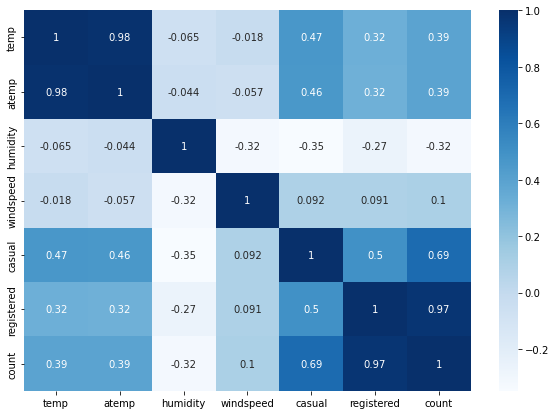

<Figure size 432x288 with 0 Axes>

In [8]:
# correlation between continuous features and targets

numcols = cont_cols + targets
corr_mat = np.around(eda_df[numcols].corr(), 3)
plt.figure(figsize=(10,7))
sns.heatmap(corr_mat, annot=True, cmap='Blues')
plt.show() # interesting features: temp, humidity
plt.clf()

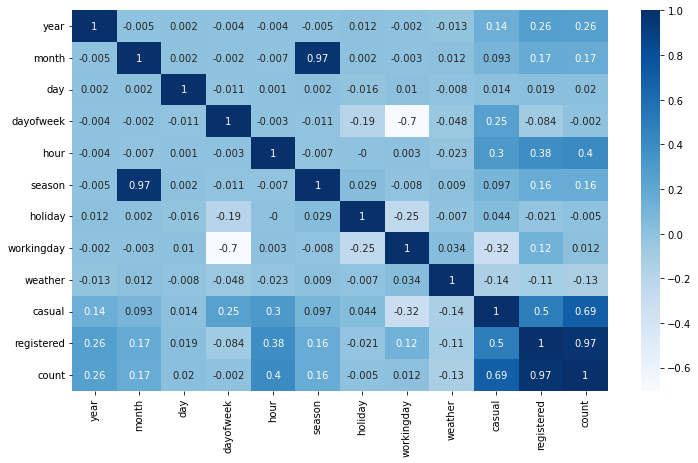

<Figure size 432x288 with 0 Axes>

In [9]:
# correlation between categorical features and targets

catcols = cat_cols + targets
corr_mat = np.around(eda_df[catcols].corr(), 3)
plt.figure(figsize=(12,7))
sns.heatmap(corr_mat, annot=True, cmap='Blues')
plt.show() # interesting features: year, hour, season, weather
plt.clf()

In [10]:
# converting categorical features to actual representation

months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
weekdays = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
seasons = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
weather = {1:'clear', 2:'cloudy', 3:'light rain', 4:'snowy'}
eda_df['month'] = eda_df['month'].map(months)
eda_df['dayofweek'] = eda_df['dayofweek'].map(weekdays)
eda_df['season'] = eda_df['season'].map(seasons)
eda_df['weather'] = eda_df['weather'].map(weather)

eda_df.head()

,year,month,day,dayofweek,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,Jan,1,Sat,0,spring,0,0,clear,9.84,14.395,81,0.0,3,13,16
1,2011,Jan,1,Sat,1,spring,0,0,clear,9.02,13.635,80,0.0,8,32,40
2,2011,Jan,1,Sat,2,spring,0,0,clear,9.02,13.635,80,0.0,5,27,32
3,2011,Jan,1,Sat,3,spring,0,0,clear,9.84,14.395,75,0.0,3,10,13
4,2011,Jan,1,Sat,4,spring,0,0,clear,9.84,14.395,75,0.0,0,1,1


In [11]:
# Exploring the seasonal statistics of ['temp', 'atemp', 'humidity', 'windspeed']

for feature in cont_cols:
    print(eda_df.groupby('season')[[feature]].agg(['min','mean','std','max']))
    print("")

         temp                            
          min       mean       std    max
season                                   
fall    15.58  28.789111  3.898157  41.00
spring   0.82  12.530491  5.186492  29.52
summer   9.84  22.823483  5.159616  38.54
winter   5.74  16.649239  4.742176  30.34

         atemp                             
           min       mean       std     max
season                                     
fall    12.120  32.540783  4.594888  45.455
spring   0.760  15.228956  6.092218  32.575
summer  11.365  26.647098  5.491321  43.940
winter   7.575  20.059909  5.264197  34.090

       humidity                           
            min       mean        std  max
season                                    
fall         17  64.123674  17.217859  100
spring        0  56.297841  20.158420  100
summer       16  60.852909  20.179655  100
winter       16  66.173738  17.813446  100

       windspeed                              
             min       mean       std      max


In [12]:
# Exploring the yearly statistics of ['temp', 'atemp', 'humidity', 'windspeed']

for feature in cont_cols:
    print(eda_df.groupby('year')[[feature]].agg(['min','mean','std','max']))
    print("")

      temp                            
       min       mean       std    max
year                                  
2011  2.46  19.751988  7.951694  38.54
2012  0.82  20.706051  7.600352  41.00

     atemp                             
       min       mean       std     max
year                                   
2011  3.03  23.157086  8.619132  43.940
2012  0.76  24.149254  8.300001  45.455

     humidity                           
          min       mean        std  max
year                                    
2011        0  63.405017  19.780518  100
2012       16  60.379575  18.578008  100

     windspeed                              
           min       mean       std      max
year                                        
2011       0.0  12.924144  8.354137  56.9969
2012       0.0  12.675605  7.970774  47.9988



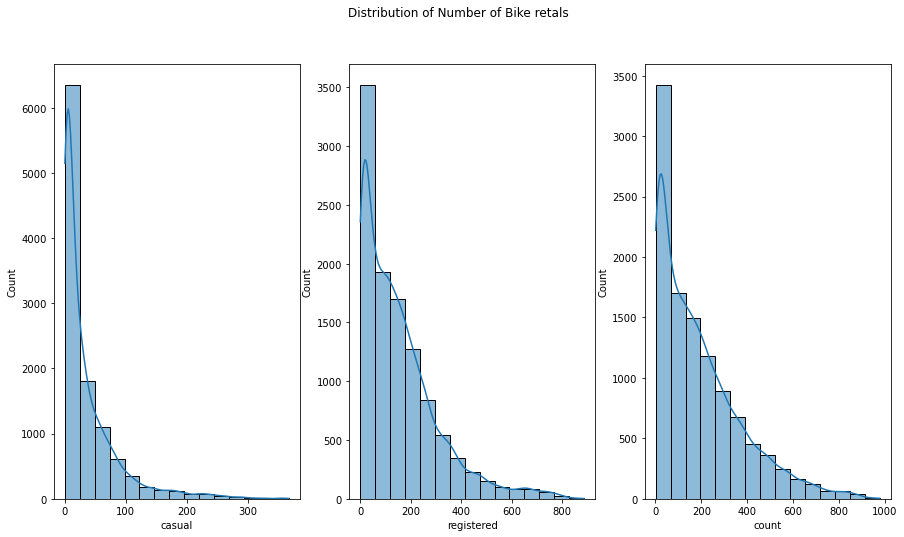

<Figure size 432x288 with 0 Axes>

In [13]:
# distribution of targets

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
for i in range(3):
    sns.histplot(data=eda_df, bins=15, x=targets[i], ax=axs[i], kde=True)
fig.suptitle('Distribution of Number of Bike retals')
plt.show()
plt.clf()

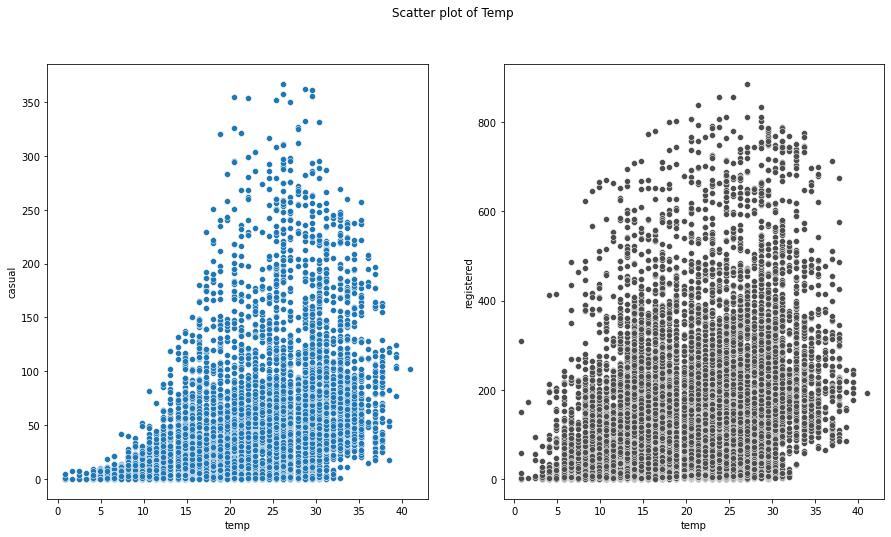

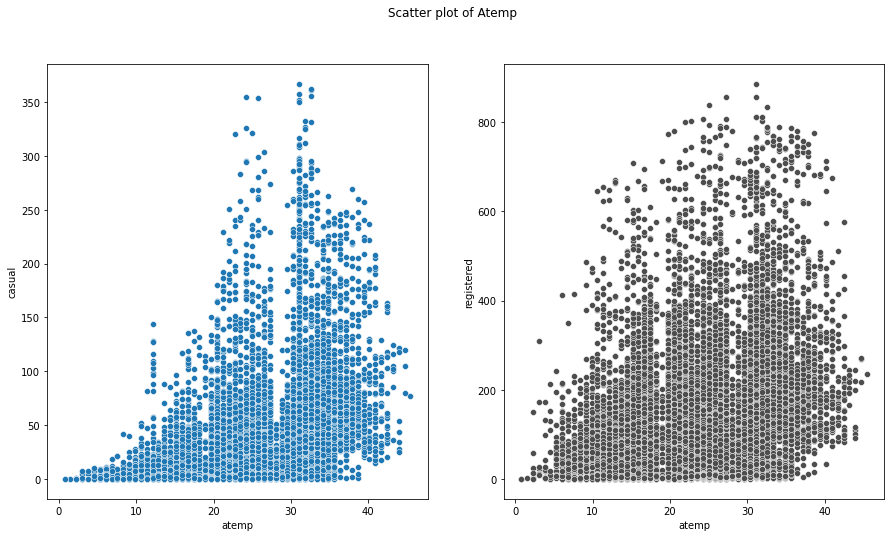

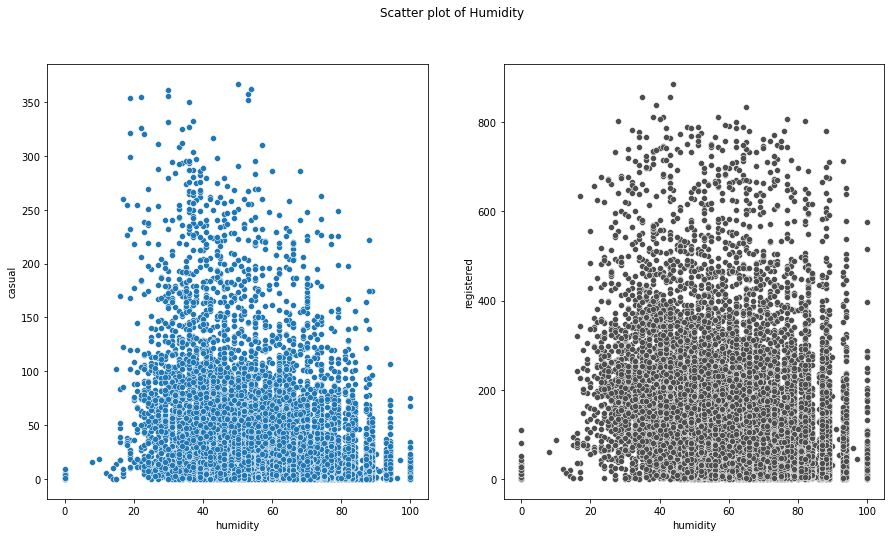

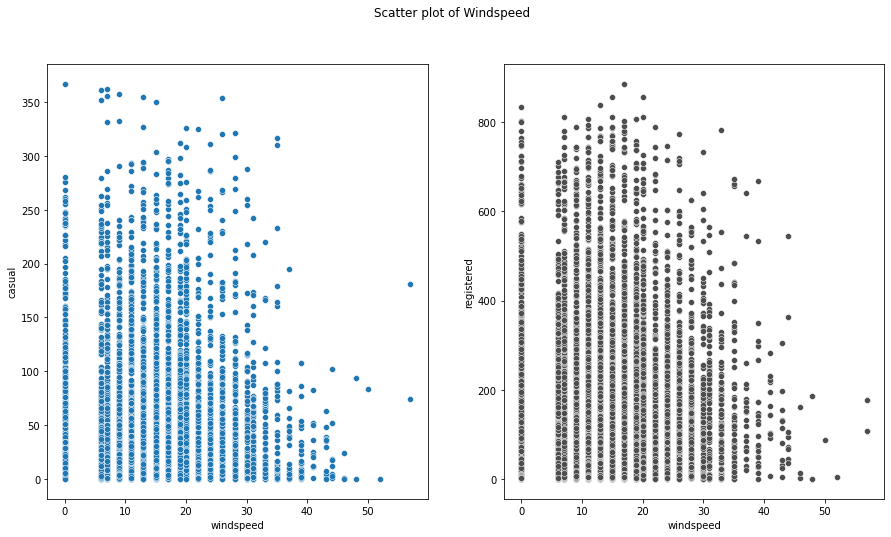

<Figure size 432x288 with 0 Axes>

In [14]:
# scatter plot of continuous features against target features

for feature in cont_cols:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    sns.scatterplot(data=eda_df, x=feature, y=targets[0], ax=axs[0])
    sns.scatterplot(data=eda_df, x=feature, y=targets[1], ax=axs[1], color=ach)
    fig.suptitle(f'Scatter plot of {feature.title()}')
    plt.show()
plt.clf()

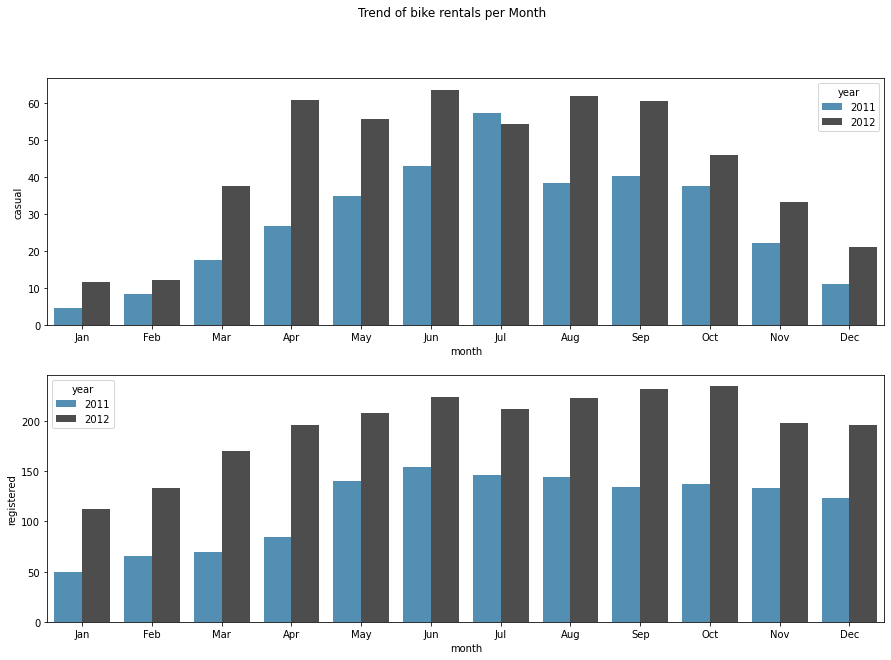

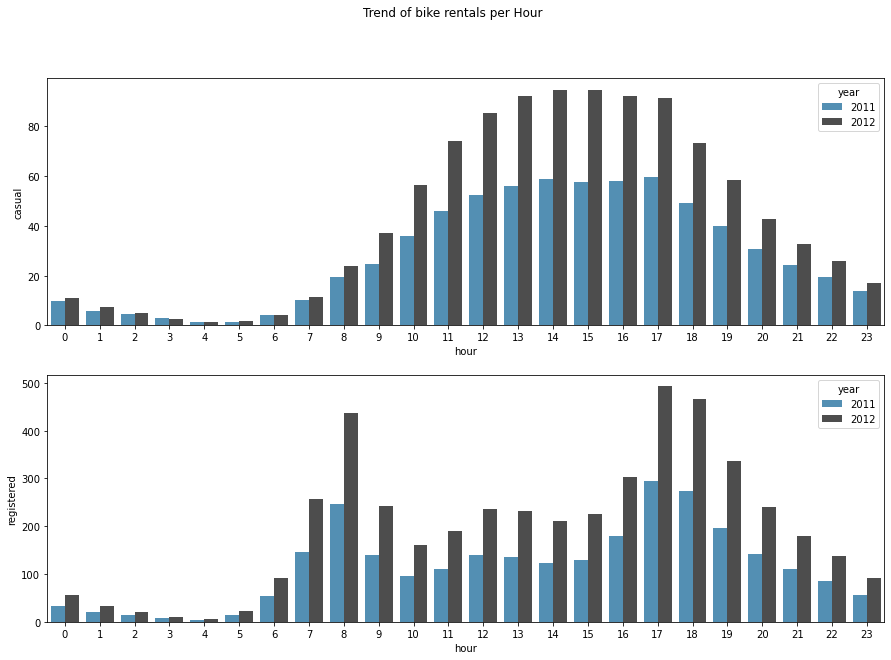

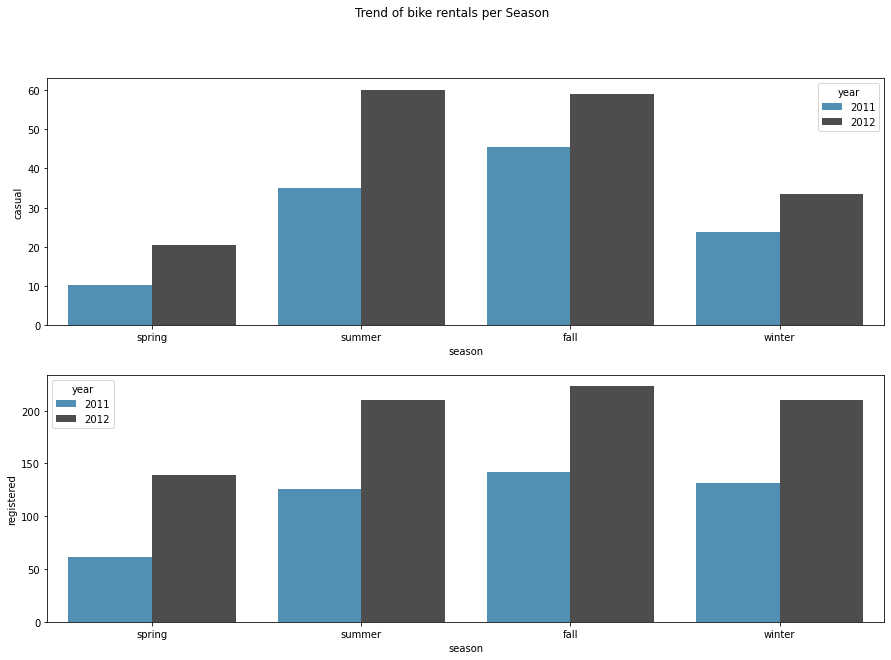

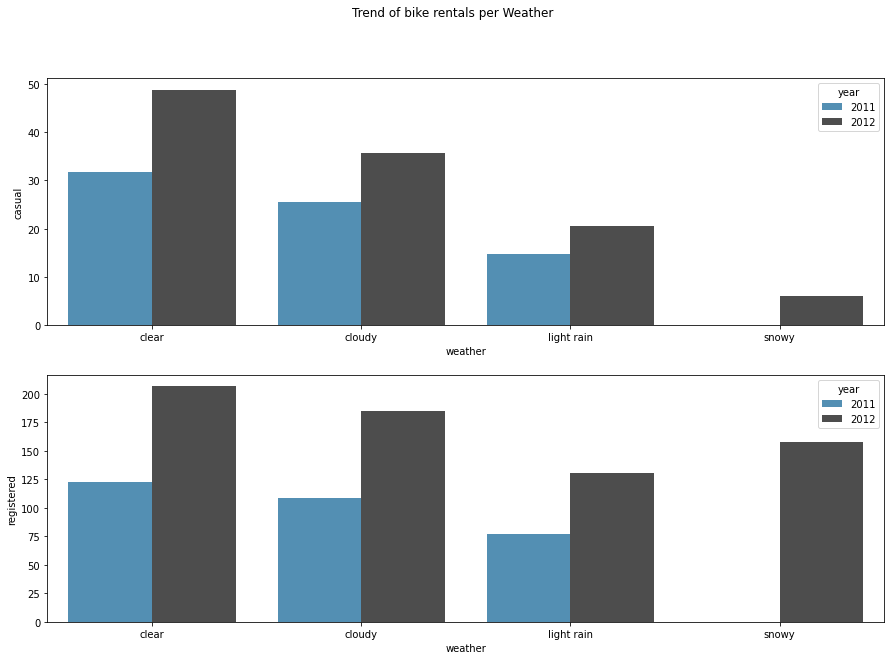

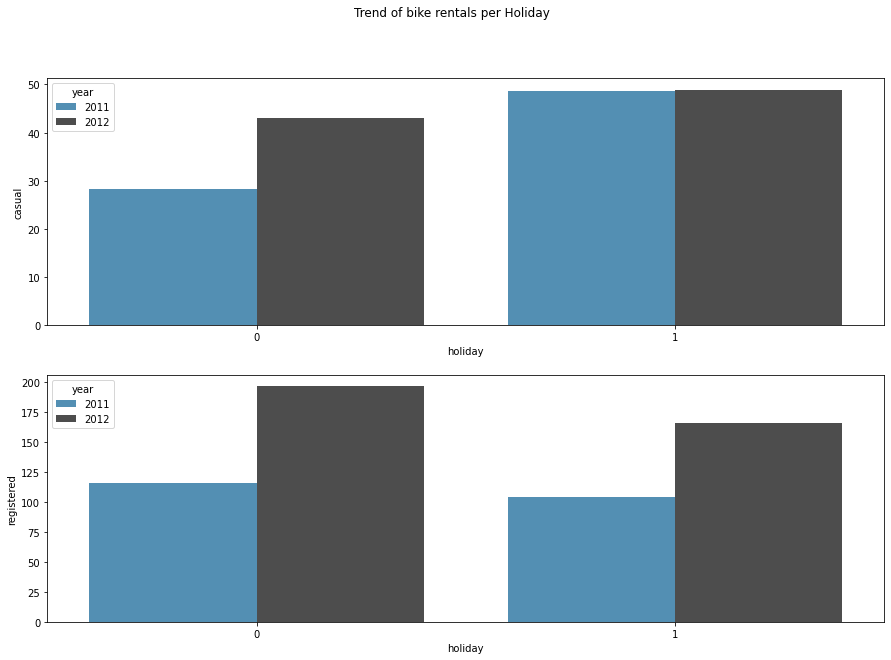

<Figure size 432x288 with 0 Axes>

In [15]:
# bar chart of categorical features
# exploring the trend of bike rental in both years (2011 and 2012)

features_of_interest = ['month', 'hour', 'season', 'weather', 'holiday']
for feature in features_of_interest:
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
    sns.barplot(data=eda_df, x=feature, y=targets[0], hue='year', palette=blue+ach, ax=axs[0], errorbar=None)
    sns.barplot(data=eda_df, x=feature, y=targets[1], hue='year', palette=blue+ach, ax=axs[1], errorbar=None)
    fig.suptitle(f'Trend of bike rentals per {feature.title()}')
    plt.show()
plt.clf()

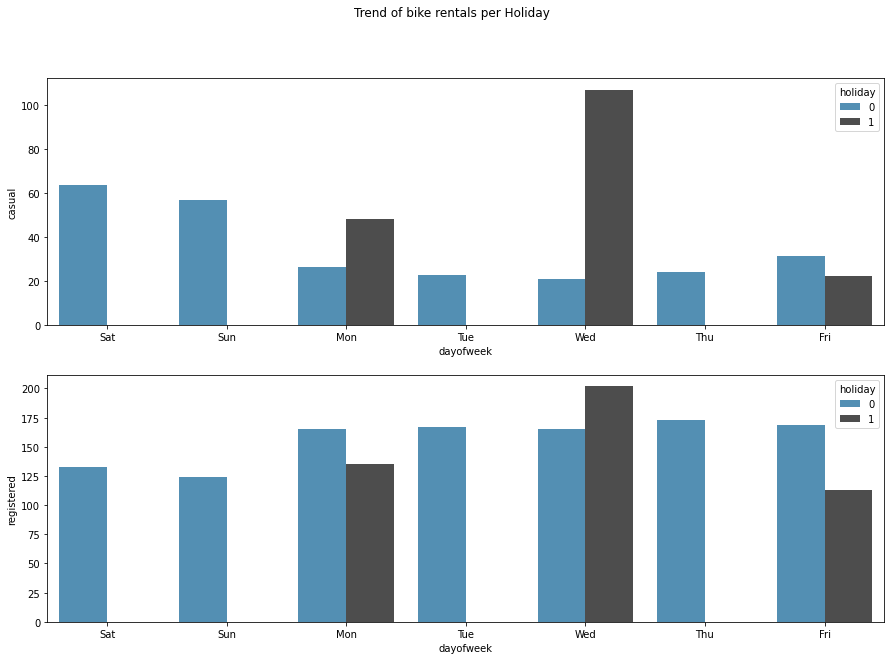

<Figure size 432x288 with 0 Axes>

In [16]:
# trend of bike sharing during the days of the week when its a holiday

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.barplot(data=eda_df, x='dayofweek', y=targets[0], hue='holiday', palette=blue+ach, ax=axs[0], errorbar=None)
sns.barplot(data=eda_df, x='dayofweek', y=targets[1], hue='holiday', palette=blue+ach, ax=axs[1], errorbar=None)
fig.suptitle(f'Trend of bike rentals per {feature.title()}')
plt.show()
plt.clf()

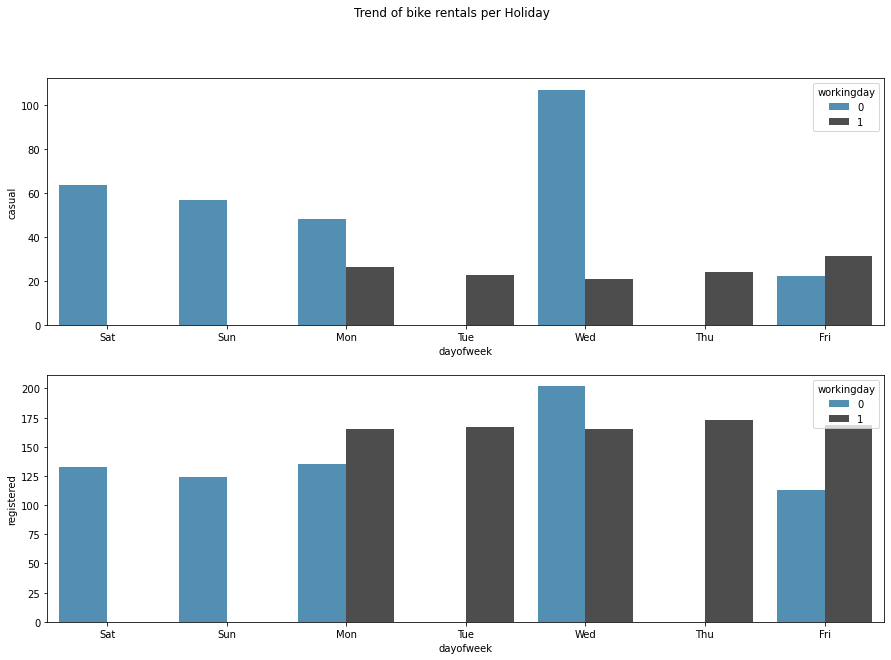

<Figure size 432x288 with 0 Axes>

In [17]:
# trend of bike sharing during the days of the week when its a working day

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.barplot(data=eda_df, x='dayofweek', y=targets[0], hue='workingday', palette=blue+ach, ax=axs[0], errorbar=None)
sns.barplot(data=eda_df, x='dayofweek', y=targets[1], hue='workingday', palette=blue+ach, ax=axs[1], errorbar=None)
fig.suptitle(f'Trend of bike rentals per {feature.title()}')
plt.show()
plt.clf()

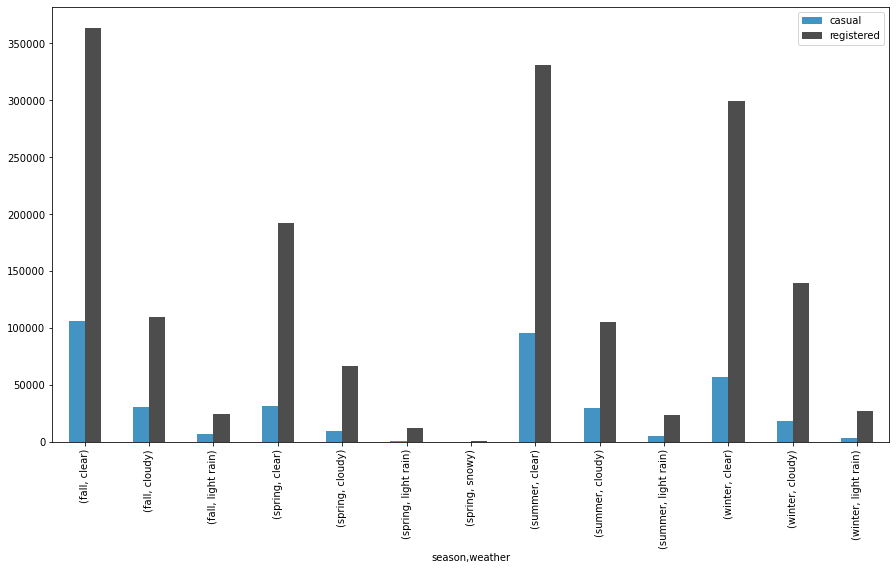

<Figure size 432x288 with 0 Axes>

In [18]:
# number of bike rentals based on the season and weather

group_season_weather = eda_df.groupby(['season','weather'])[['casual','registered']].sum()
group_season_weather.plot.bar(figsize=(15,8), color=blue+ach)
plt.legend()
plt.show()
plt.clf()

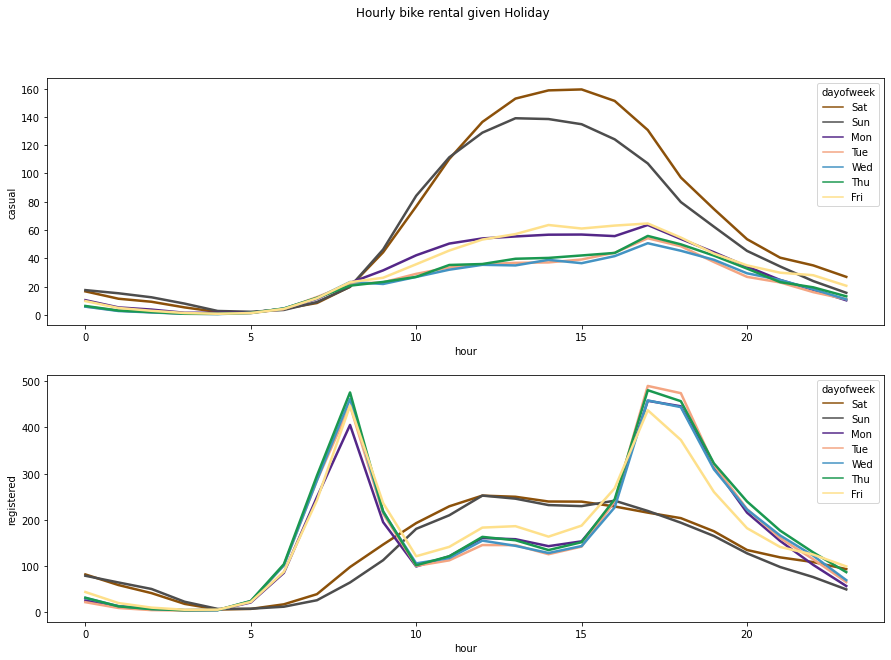

<Figure size 432x288 with 0 Axes>

In [19]:
# investigating the trend of rent during day of week and time by casual and registered bikers
palette = ['#8c510a','#4d4d4d','#542788','#f4a582','#4393c3','#1a9850','#fee08b']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.lineplot(data=eda_df, x='hour', y=targets[0], linewidth=2.5, palette=palette, hue='dayofweek', ax=axs[0], err_style=None)
sns.lineplot(data=eda_df, x='hour', y=targets[1], linewidth=2.5, palette=palette, hue='dayofweek', ax=axs[1], err_style=None)
fig.suptitle(f'Hourly bike rental given {feature.title()}')
plt.show()
plt.clf()

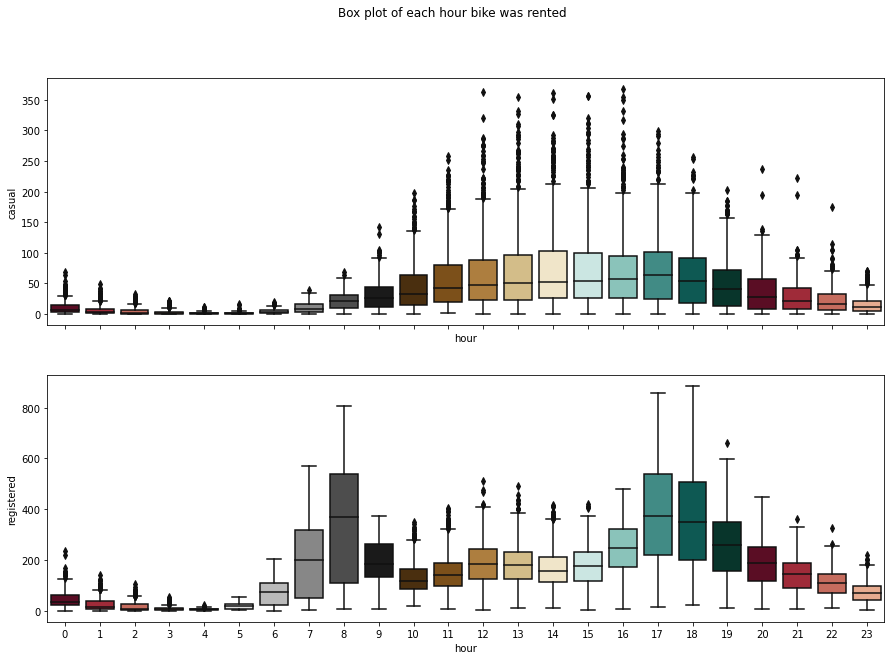

<Figure size 432x288 with 0 Axes>

In [20]:
# investigating the variations of the hour the bike were rented with respect to the target features
hour = eda_df['hour']

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
sns.boxplot(data=eda_df, x=hour, y=targets[0], ax=axs[0], palette=div2+div1)
sns.boxplot(data=eda_df, x=hour, y=targets[1], ax=axs[1], palette=div2+div1)
fig.suptitle('Box plot of each hour bike was rented')
plt.show()
plt.clf()

#### Data Qualitty Report
__Continuous Features__ <br>
```['temp', 'atemp', 'humidity', 'windspeed']```

In [21]:
# Description of continuous features
cont_description = ['Temperature in Celsius', 'Feels like temperature in Celsius',
                    'Relative humidity', 'Wind speed', 'Number of non-registered user rentals',
                    'Number of registed user rentals', 'Total number of rentals']

continuous_features_dqr = pd.DataFrame()

for idx, feature in enumerate(cont_cols):
    cont_dqr = pd.DataFrame()
    cont_dqr['Features'] = [feature]
    cont_dqr['Description'] = [cont_description[idx]]
    cont_dqr['Count'] = [eda_df[feature].shape[0]]
    cont_dqr['% of Missing'] = [eda_df[feature].isnull().sum() / eda_df[feature].shape[0]]
    cont_dqr['Card.'] = [eda_df[feature].nunique()]
    cont_dqr['Min #'] = [eda_df[feature].min()]
    cont_dqr['Q1'] = [eda_df[feature].describe()[4]]
    cont_dqr['Median'] = [eda_df[feature].median()]
    cont_dqr['Q3'] = [eda_df[feature].describe()[6]]
    cont_dqr['Max #'] = [eda_df[feature].max()]
    cont_dqr['Std. Dev.'] = [eda_df[feature].std()]
    continuous_features_dqr = pd.concat([continuous_features_dqr, cont_dqr],
                                         axis=0, ignore_index=True)
    
continuous_features_dqr

,Features,Description,Count,% of Missing,Card.,Min #,Q1,Median,Q3,Max #,Std. Dev.
0,temp,Temperature in Celsius,10886,0.0,49,0.82,13.9400,20.500,26.2400,41.0000,7.791590
1,atemp,Feels like temperature in Celsius,10886,0.0,60,0.76,16.6650,24.240,31.0600,45.4550,8.474601
2,humidity,Relative humidity,10886,0.0,89,0.00,47.0000,62.000,77.0000,100.0000,19.245033
3,windspeed,Wind speed,10886,0.0,28,0.00,7.0015,12.998,16.9979,56.9969,8.164537


__Categorical Features__ <br>
```['year', 'month', 'day', 'dayofweek', 'hour', 'season', 'holiday', 'workingday', 'weather']```

In [22]:
# Description of categorical features
cat_description = ['Year of rental', 'Month of rental', 'Day of rental', 'Day of week',
                   'Hour of day', 'Current Season', 'Day is holiday or not', 
                    'Day is working day or not', 'Current weather']

categorical_features_dqr = pd.DataFrame()

for idx, feature in enumerate(cat_cols):
    cat_dqr = pd.DataFrame()
    cat_dqr['Features'] = [feature]
    cat_dqr['Description'] = [cat_description[idx]]
    cat_dqr['Count'] = [eda_df[feature].shape[0]]
    cat_dqr['% of Missing'] = [eda_df[feature].isnull().sum() / eda_df[feature].shape[0]]
    cat_dqr['Card.'] = [eda_df[feature].nunique()]
    cat_dqr['1st Mode'] = [eda_df[feature].mode(dropna=True)[0]]
    cat_dqr['1st Mode Freq.'] = [eda_df[eda_df[feature] == cat_dqr['1st Mode'][0]].shape[0]]
    cat_dqr['1st Mode %'] = np.around(cat_dqr['1st Mode Freq.'] / cat_dqr['Count'] * 100, 2)
    cat_dqr['2nd Mode'] = [eda_df[eda_df[feature] != cat_dqr['1st Mode'][0]][feature].mode(dropna=True)[0]]
    cat_dqr['2nd Mode Freq.'] = [eda_df[eda_df[feature] == cat_dqr['2nd Mode'][0]].shape[0]]
    cat_dqr['2nd Mode %'] = np.around(cat_dqr['2nd Mode Freq.'] / cat_dqr['Count'] * 100, 2)
    categorical_features_dqr = pd.concat([categorical_features_dqr, cat_dqr],
                                         axis=0, ignore_index=True)
    
categorical_features_dqr

,Features,Description,Count,% of Missing,Card.,1st Mode,1st Mode Freq.,1st Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
0,year,Year of rental,10886,0.0,2,2012,5464,50.19,2011,5422,49.81
1,month,Month of rental,10886,0.0,12,Aug,912,8.38,Dec,912,8.38
2,day,Day of rental,10886,0.0,19,1,575,5.28,5,575,5.28
3,dayofweek,Day of week,10886,0.0,7,Sat,1584,14.55,Sun,1579,14.50
4,hour,Hour of day,10886,0.0,24,12,456,4.19,13,456,4.19
5,season,Current Season,10886,0.0,4,winter,2734,25.11,fall,2733,25.11
6,holiday,Day is holiday or not,10886,0.0,2,0,10575,97.14,1,311,2.86
7,workingday,Day is working day or not,10886,0.0,2,1,7412,68.09,0,3474,31.91
8,weather,Current weather,10886,0.0,4,clear,7192,66.07,cloudy,2834,26.03


### Dealing with Missing Values and Outliers

__Missing Values__

In [23]:
# checking for missing values in the eda dataset
eda_df.isnull().any()

year          False
month         False
day           False
dayofweek     False
hour          False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

__Outliers__

In [24]:
# investigating and removing potential outliers in the dataset

def remove_outlier(df):
    """ Function Name: remove outliers
            This function takes in a dataframe and removes
            top and bottom k% outliers in count and also
            take out dangerous windspeed (>29mph)
    """
    # At 30mph or, the wind makes cycling quite difficult,
    # even for the more experienced cyclist.
    windtresh  = 29
    tresh = df['windspeed'] > windtresh
    df = df.drop(index=df[tresh].index)

    k = 2
    lower = df['count'] < df['count'].quantile(k/100)
    upper = df['count'] > df['count'].quantile(1-k/100)
    df = df.drop(index=df[lower].index)
    df = df.drop(index=df[upper].index)
        
    return df

outlier_removed = remove_outlier(eda_df)
print(eda_df.shape, outlier_removed.shape)

(10886, 16) (10155, 16)


In [25]:
""" UNCOMMENT ME """

# # visualizing the change in distribution for the continuous columns

# for feature in numcols:
#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
#     sns.histplot(data=eda_df, x=feature, bins=20, kde=True, ax=axs[0])
#     sns.histplot(data=outlier_removed, x=feature, bins=20, kde=True, ax=axs[1])
#     plt.show()
# plt.clf()


# # visualizing the change in variation for the categorical columns

# for feature in cat_cols:
#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
#     sns.boxplot(data=eda_df, x=feature, y=targets[2], ax=axs[0], palette=div2+div1)
#     sns.boxplot(data=outlier_removed, x=feature, y=targets[2], ax=axs[1], palette=div2+div1)
#     plt.show()
# plt.clf()

' UNCOMMENT ME '

### Normalizing Continuours Features

In [26]:
def normalize(df, cols):
    """ Function Name: Normalize
            This function takes a dataframe and specified numerical
            columns and transforms them between [0, 1]
    """
    for feature in cols:
        minval, maxval = df[feature].min(), df[feature].max()
        df[feature] = ( df[feature] - minval ) / ( maxval - minval )

    return df

eda_df = normalize(outlier_removed, cont_cols)
eda_df.head()

,year,month,day,dayofweek,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,Jan,1,Sat,0,spring,0,0,clear,0.224490,0.293127,0.81,0.0,3,13,16
1,2011,Jan,1,Sat,1,spring,0,0,clear,0.204082,0.275831,0.80,0.0,8,32,40
2,2011,Jan,1,Sat,2,spring,0,0,clear,0.204082,0.275831,0.80,0.0,5,27,32
3,2011,Jan,1,Sat,3,spring,0,0,clear,0.224490,0.293127,0.75,0.0,3,10,13
6,2011,Jan,1,Sat,6,spring,0,0,clear,0.204082,0.275831,0.80,0.0,2,0,2


### Feature Selection and Transformation

__Selection__ <br>
`keep features: {atemp, humidity, year, hour, season, workingday, weather}`

In [27]:
keep = ['year', 'hour', 'season', 'workingday', 'weather', 'atemp', 'humidity', 'count']
eda_df = eda_df[keep]
eda_df.head()

,year,hour,season,workingday,weather,atemp,humidity,count
0,2011,0,spring,0,clear,0.293127,0.81,16
1,2011,1,spring,0,clear,0.275831,0.80,40
2,2011,2,spring,0,clear,0.275831,0.80,32
3,2011,3,spring,0,clear,0.293127,0.75,13
6,2011,6,spring,0,clear,0.275831,0.80,2


__Transformation__

In [28]:
# creating dummies for categorical features

dummy = ['year', 'hour', 'season', 'workingday', 'weather']
eda_df[dummy] = eda_df[dummy].astype('object')
eda_df = pd.get_dummies(eda_df, columns=dummy, drop_first=True)
eda_df.head()

,atemp,humidity,count,year_2012,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,hour_21,hour_22,hour_23,season_spring,season_summer,season_winter,workingday_1,weather_cloudy,weather_light rain,weather_snowy
0,0.293127,0.81,16,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.275831,0.80,40,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.275831,0.80,32,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.293127,0.75,13,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0.275831,0.80,2,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [29]:
# binning the target feature into 4 bins
eda_bin, eda_iqr = eda_df.copy(), eda_df.copy()
group = {'few':1, 'okay':2, 'enough':3, 'alot':4}

def bin_target(df, target='count'):
    temp = df[target].to_numpy()
    new = []
    lower, upper = np.min(temp), np.max(temp)
    inc = (upper - lower) / 4

    for val in temp:
        if val <= inc :
            new.append('few')
        elif val <= 2*inc :
            new.append('okay')
        elif val <= 3*inc :
            new.append('enough')
        else:
            new.append('alot')
    df[target] = new

    return df

def iqr_target(df, target='count'):
    temp = df[target].to_numpy()
    new = []
    lower, med, upper = df[target].quantile([.25, .5, .75])

    for val in temp:
        if val <= lower :
            new.append('few')
        elif val <= med :
            new.append('okay')
        elif val <= upper :
            new.append('enough')
        else:
            new.append('alot')
    df[target] = new

    return df

eda_bin = bin_target(eda_bin, 'count')
eda_bin['count'] = eda_bin['count'].map(group)
eda_iqr = iqr_target(eda_iqr, 'count')
eda_iqr['count'] = eda_iqr['count'].map(group)

### MODEL SELECTION AND EVALUATION
`Data sets used: {eda_df, eda_bin}`

In [30]:
# inporting useful librabries and test data set

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, mean_squared_log_error, classification_report

### Regression Models
1. Simple Linear Regression
2. Decision Tree Regression

In [31]:
# splitting datasets

X = eda_df.drop(columns='count')
y = eda_df['count']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.7, random_state=2)
print(Xtest.shape, Xtrain.shape)

(3047, 33) (7108, 33)


R2 accuracy: 
Train data = 0.6816624599219869 
Test data = 0.6682932242996071


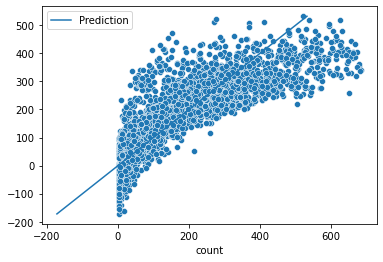

In [32]:
# Linear Regression
linmdl = LinearRegression()
linmdl.fit(Xtrain, ytrain)
ypred = linmdl.predict(Xtest)
r2train = linmdl.score(Xtrain, ytrain)
r2test = linmdl.score(Xtest, ytest)
print(f'R2 accuracy: \nTrain data = {r2train} \nTest data = {r2test}')
# err = mean_squared_log_error(ytest1, ypred) # !error; prediction contains negative values ??? ---> sparse data (due to one hot encoding)!

sns.scatterplot(x=ytest, y=ypred)
sns.lineplot(x=ypred, y=ypred, label='Prediction')
plt.legend()
plt.show()

In [33]:
# take the log transform of target values
yln_train, yln_test = ytrain.copy(), ytest.copy()
yln_train, yln_test = np.log(yln_train), np.log(yln_test)

R2 accuracy: 
Train data = 0.9434473034235276 
Test data = 0.9413128504500212


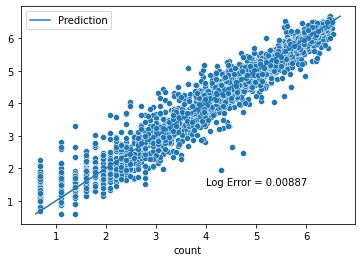

In [34]:
# Linear Regression with polynomial features
# creating and fitting polynomial features

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
polyfeats = poly.fit_transform(Xtrain)

polyreg = LinearRegression()
polyreg.fit(polyfeats, yln_train)
yln_pred = polyreg.predict(poly.fit_transform(Xtest))
r2train = polyreg.score(poly.fit_transform(Xtrain), yln_train)
r2p = polyreg.score(poly.fit_transform(Xtest), yln_test)
err = mean_squared_log_error(yln_test, yln_pred)
print(f'R2 accuracy: \nTrain data = {r2train} \nTest data = {r2p}')

sns.scatterplot(x=yln_test, y=yln_pred)
sns.lineplot(x=yln_pred, y=yln_pred, label='Prediction')
plt.text(4, 1.5, f'Log Error = {err:.5f}')
plt.legend()
plt.show()

R2 accuracy: 
Train data = 0.8786258229144126 
Test data = 0.7759066005508889


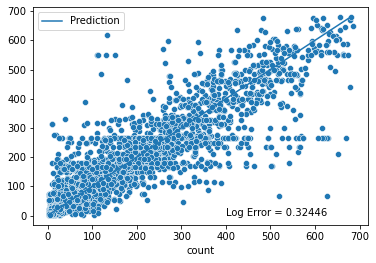

In [35]:
# Decision Tree Regression

treereg = DecisionTreeRegressor(criterion='absolute_error', max_depth=20, random_state=2)
treereg.fit(Xtrain, ytrain)
ypred_dtr = treereg.predict(Xtest)
r2train = treereg.score(Xtrain, ytrain)
r2test = treereg.score(Xtest, ytest)
err = mean_squared_log_error(ytest, ypred_dtr)
print(f'R2 accuracy: \nTrain data = {r2train} \nTest data = {r2test}')

sns.scatterplot(x=ytest, y=ypred_dtr)
sns.lineplot(x=ypred_dtr, y=ypred_dtr, label='Prediction')
plt.text(400, 0, f'Log Error = {err:.5f}')
plt.legend()
plt.show()

### Classification Models
1. Decision Tree Classifier
2. K-Nearest Neighbors

##### [a] Using binned targets
few $ \leq $ 170.75 <br>
170.75 $ < $ okay $ \leq $ 341.5 <br>
341.5 $ < $ enough $ \leq $ 512.25 <br>
512.25 $ < $ alot

In [36]:
# splitting datasets

X = eda_bin.drop(columns='count')
y = eda_bin['count']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.7, random_state=2)
print(Xtest.shape, Xtrain.shape)

(3047, 33) (7108, 33)


Test Accuracy Score = 78.34%
Train Accuracy Score = 93.70%


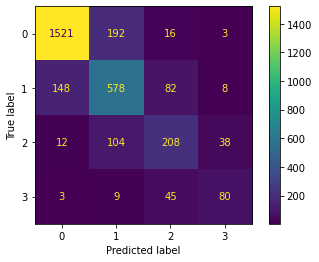

              precision    recall  f1-score   support

         few       0.90      0.88      0.89      1732
        okay       0.65      0.71      0.68       816
      enough       0.59      0.57      0.58       362
        alot       0.62      0.58      0.60       137

    accuracy                           0.78      3047
   macro avg       0.69      0.69      0.69      3047
weighted avg       0.79      0.78      0.78      3047



In [37]:
# Decision Tree Classification

treeclf = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=2)
treeclf.fit(Xtrain, ytrain)
ypred_dt = treeclf.predict(Xtest)
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest,ypred_dt) * 100) )
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, treeclf.predict(Xtrain) ) * 100) )

# confusion matrix
conf_metrix = confusion_matrix(ytest, ypred_dt)
conf_metrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_metrix)#, display_labels=['few', 'okay', 'enough', 'alot'])
conf_metrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_dt, target_names=group))

Test Accuracy Score = 81.56%
Train Accuracy Score = 85.19%


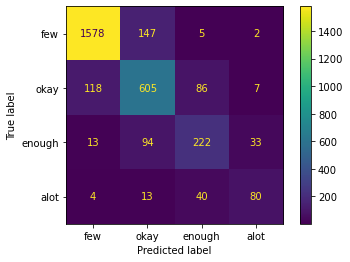

              precision    recall  f1-score   support

         few       0.92      0.91      0.92      1732
        okay       0.70      0.74      0.72       816
      enough       0.63      0.61      0.62       362
        alot       0.66      0.58      0.62       137

    accuracy                           0.82      3047
   macro avg       0.73      0.71      0.72      3047
weighted avg       0.82      0.82      0.82      3047



In [38]:
# K-Nearest Neighbors

knnclf = KNeighborsClassifier(n_neighbors=9, metric='euclidean')
knnclf.fit(Xtrain, ytrain)
ypred_k = knnclf.predict(Xtest)
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest, ypred_k) * 100) )
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, knnclf.predict(Xtrain)) * 100) )

# confusion matrix
conf_metrix = confusion_matrix(ytest, ypred_k)
conf_metrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_metrix, display_labels=['few', 'okay', 'enough', 'alot'])
conf_metrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_k, target_names=group))

##### [b] Uing IQR targets
few $ \leq $ Q1 <br>
Q1 $ < $ okay $ \leq $ Q2 <br>
Q2 $ < $ enough $ \leq $ Q3 <br>
Q3 $ < $ alot

In [39]:
# splitting datasets

X = eda_iqr.drop(columns='count')
y = eda_iqr['count']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.7, random_state=2)
print(Xtest.shape, Xtrain.shape)

(3047, 33) (7108, 33)


Test Accuracy Score = 73.35%
Train Accuracy Score = 86.99%


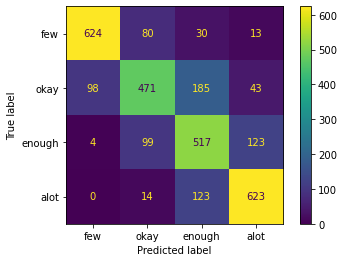

              precision    recall  f1-score   support

         few       0.86      0.84      0.85       747
        okay       0.71      0.59      0.64       797
      enough       0.60      0.70      0.65       743
        alot       0.78      0.82      0.80       760

    accuracy                           0.73      3047
   macro avg       0.74      0.74      0.73      3047
weighted avg       0.74      0.73      0.73      3047



In [40]:
# Decision Tree Classification

treeclf = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=2)
treeclf.fit(Xtrain, ytrain)
ypred_dt = treeclf.predict(Xtest)
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest,ypred_dt) * 100) )
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, treeclf.predict(Xtrain) ) * 100) )

# confusion matrix
conf_metrix = confusion_matrix(ytest, ypred_dt)
conf_metrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_metrix, display_labels=['few', 'okay', 'enough', 'alot'])
conf_metrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_dt, target_names=group))

Accuracy Score = 79.29%
Train Accuracy Score = 82.82%


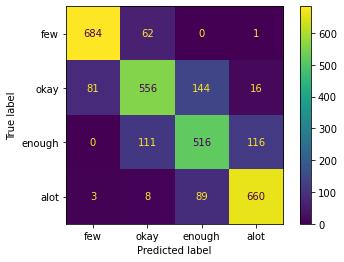

              precision    recall  f1-score   support

         few       0.89      0.92      0.90       747
        okay       0.75      0.70      0.72       797
      enough       0.69      0.69      0.69       743
        alot       0.83      0.87      0.85       760

    accuracy                           0.79      3047
   macro avg       0.79      0.79      0.79      3047
weighted avg       0.79      0.79      0.79      3047



In [41]:
# K-Nearest Neighbors
knnclf = KNeighborsClassifier(n_neighbors=9, metric='euclidean')
knnclf.fit(Xtrain, ytrain)
ypred_k = knnclf.predict(Xtest)
print('Accuracy Score = {:.2f}%'.format(accuracy_score(ytest,ypred_k) * 100) )
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, knnclf.predict(Xtrain) ) * 100) )

# confusion matrix
conf_metrix = confusion_matrix(ytest, ypred_k)
conf_metrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_metrix, display_labels=['few', 'okay', 'enough', 'alot'])
conf_metrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_k, target_names=group))